<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>

**Numerical Computations**

**Computer Engineering Department**

**Fall 2024**

**Practical Assignment 1 - Approximation and Interpolation**

**Mehran Bakhtiari**


____

This assignment explores sophisticated numerical approximation techniques, focusing on Taylor series expansions, optimized interpolation methods, and rigorous error analysis. You will implement and analyze various approximation techniques while optimizing for both accuracy and computational efficiency.

# Personal Data

In [ ]:
student_number = '401105989'
Name = 'Amirhosein'
Last_Name = 'Rezaei'

**Complete implementation of all code sections and provide detailed responses to conceptual questions. Make sure to run all the cells.**

### Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, List, Union
from time import perf_counter
from dataclasses import dataclass
import math

## Section 1: Taylor Series Expansion of Complex Functions (20 Points)
### Background
Taylor series provides a way to approximate complex functions using polynomials by expanding the function into an infinite series. This approach is particularly useful in numerical computation, as polynomial approximations are computationally efficient. Here, you will approximate the function $f(x)=e^{-x}\sin(5x)$, using Taylor series around the series expansion around $x$ = 0, examining convergence behavior for this oscillatory function. the series expansion around $x_0$ is:

$f(x) = \sum_{n=0}^{\infty} \frac{f^{(n)}(x_0)}{n!}(x-x_0)^n$

The challenge lies in:
1. Computing high-order derivatives efficiently
2. Determining optimal series truncation
3. Analyzing convergence behavior for oscillatory functions

### Task 1.1: Taylor Series Implementation (10 points)
**Step 1:** Start by writing a function that computes individual terms of the Taylor series expansion for $f(x)$.

**Step 2:** Sum the series up to a user-defined degree $n$, iteratively adding each term.

**Step 3:** Implement a convergence check by adding terms until the absolute change between consecutive terms is below a specified threshold (e.g., $10^{-6}$). This dynamic approach prevents unnecessary calculations when the series has converged.

In [84]:
@dataclass
class TaylorExpansion:
    """
    Compute and analyze Taylor series expansions for complex functions.
    """
    def __init__(self, f: Callable[[float], float],
                 df: List[Callable[[float], float]]):
        """
        Initialize with function and its derivatives.

        Args:
            f: Original function
            df: List of derivative functions [f', f'', ..., f^(n)]
        """
        self.f = f
        self.derivatives = df

    def compute_term(self, x: float, x0: float, n: int) -> float:
        """
        Compute nth term of Taylor series.

        Args:
            x: Evaluation point
            x0: Expansion point
            n: Term index

        Returns:
            Value of nth term
        """
        return ((x - x0)**n) * self.derivatives[n](x0) / math.factorial(n)

    def expand(self, x: np.ndarray, x0: float,
               max_terms: int = 50,
               tol: float = 1e-6) -> Tuple[np.ndarray, int]:
        """
        Compute Taylor series with dynamic convergence check.

        Args:
            x: Points at which to evaluate series
            x0: Expansion point
            max_terms: Maximum number of terms to include
            tol: Convergence tolerance

        Returns:
            (approximation, number of terms used)
        """
        approximation = np.zeros_like(x)
        p = - 1 * tol
        for n in range(max_terms):
            term = np.array([self.compute_term(pt, x0, n) for pt in x])
            approximation += term
            max_change = np.max(np.abs(term - p))
            p = term
            if max_change < tol:
                return approximation, n + 1
        return approximation, max_terms

In [115]:
def create_test_function() -> Tuple[Callable, List[Callable]]:
    """
    Create test function f(x) = e^(-x)sin(5x) and its derivatives.

    Returns:
        (function, list of derivatives)
    """
    def f(x):
        return np.exp(-x) * np.sin(5 * x)
    derivatives = [
        lambda x: np.exp(-x) * np.sin(5 * x),
        lambda x: np.exp(-x) * (np.cos(5 * x) * 5 - np.sin(5 * x)),
    ]
    for n in range(1, 30):
        def nth_derivative(x, n=n):
            return np.exp(-x) * (
                (-1)**n * (5**n) * np.sin(5 * x) + (-1)**(n + 1) * (5**n) * np.cos(5 * x)
            )
        derivatives.append(nth_derivative)
    return f, derivatives

### Task 1.2: Convergence Analysis and Visualization (10 points)
Plot both $f(x)$ and the Taylor series approximation over a range such as [-2, 2]. Examine where the Taylor series approximation diverges from $f(x)$, especially for larger $x$-values as Taylor series may struggle to approximate oscillatory functions accurately over larger intervals.

In [119]:
def analyze_taylor_convergence(x: np.ndarray,
                             taylor_expansion: TaylorExpansion,
                             x0: float) -> None:
    """
    Analyze and visualize Taylor series convergence.

    Args:
        x: Points for evaluation
        taylor_expansion: TaylorExpansion instance
        x0: Expansion point
    """
    original = np.array([taylor_expansion.f(pt) for pt in x])
    approximations = []
    errors = []
    for terms in range(1, 16):
        approx, _ = taylor_expansion.expand(x, x0, max_terms=terms)
        approximations.append(approx)
        errors.append(np.abs(original - approx))

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    ax1.plot(x, original, label="Original Function", color="black")
    for idx, approx in enumerate(approximations, start=1):
        ax1.plot(x, approx, label=f'{idx} Terms')
    ax1.set_title("Original function vs approximations")
    ax1.set_xlabel("x")
    ax1.set_ylabel("f(x)")
    ax1.legend()

    for idx, error in enumerate(errors, start=1):
        ax2.plot(x, error, label=f"n={idx}")
    ax2.set_title("Error convergence behavior")
    ax2.set_xlabel("x")
    ax2.set_ylabel("Error")
    ax2.legend()

    plt.tight_layout()
    plt.show()

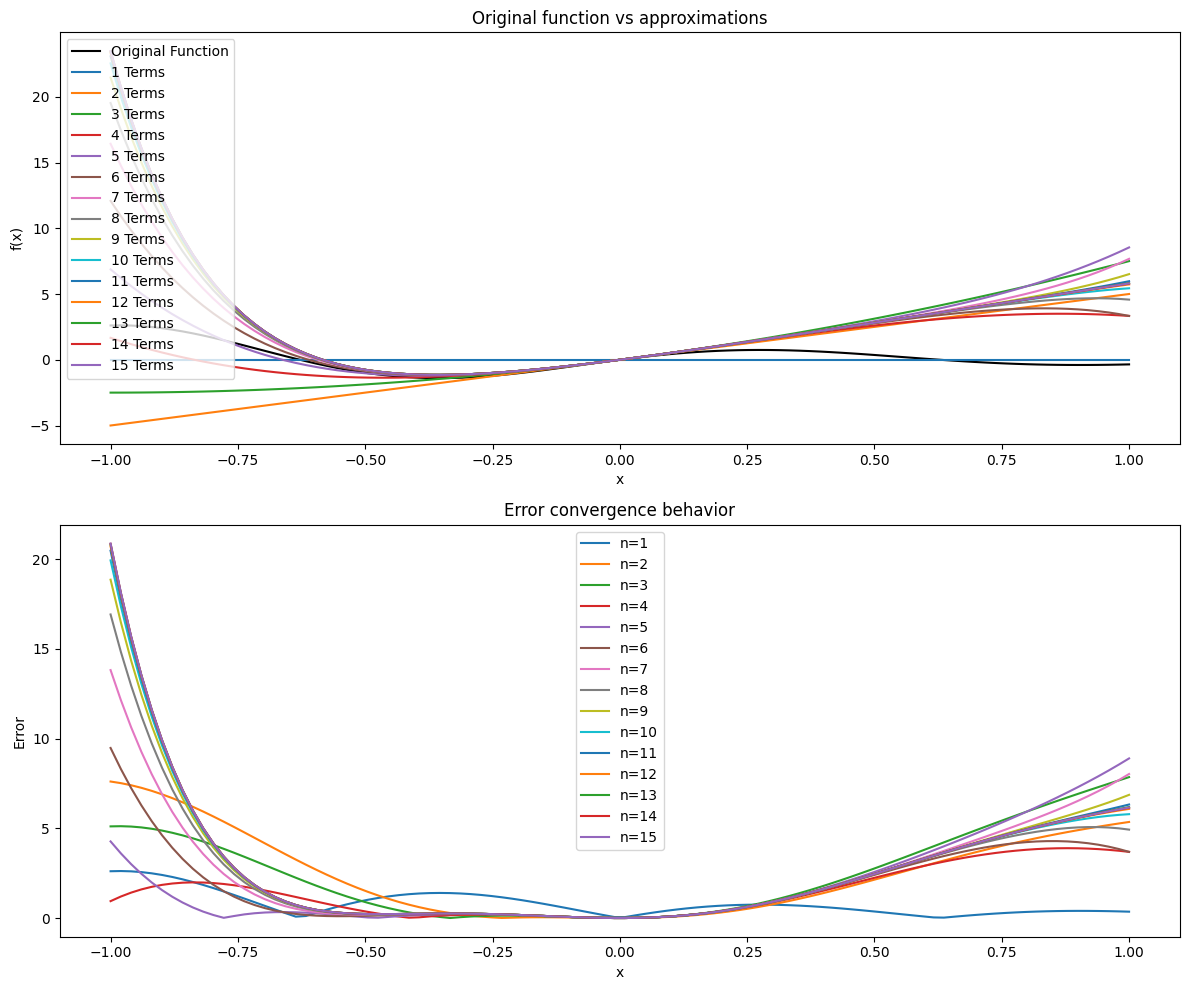

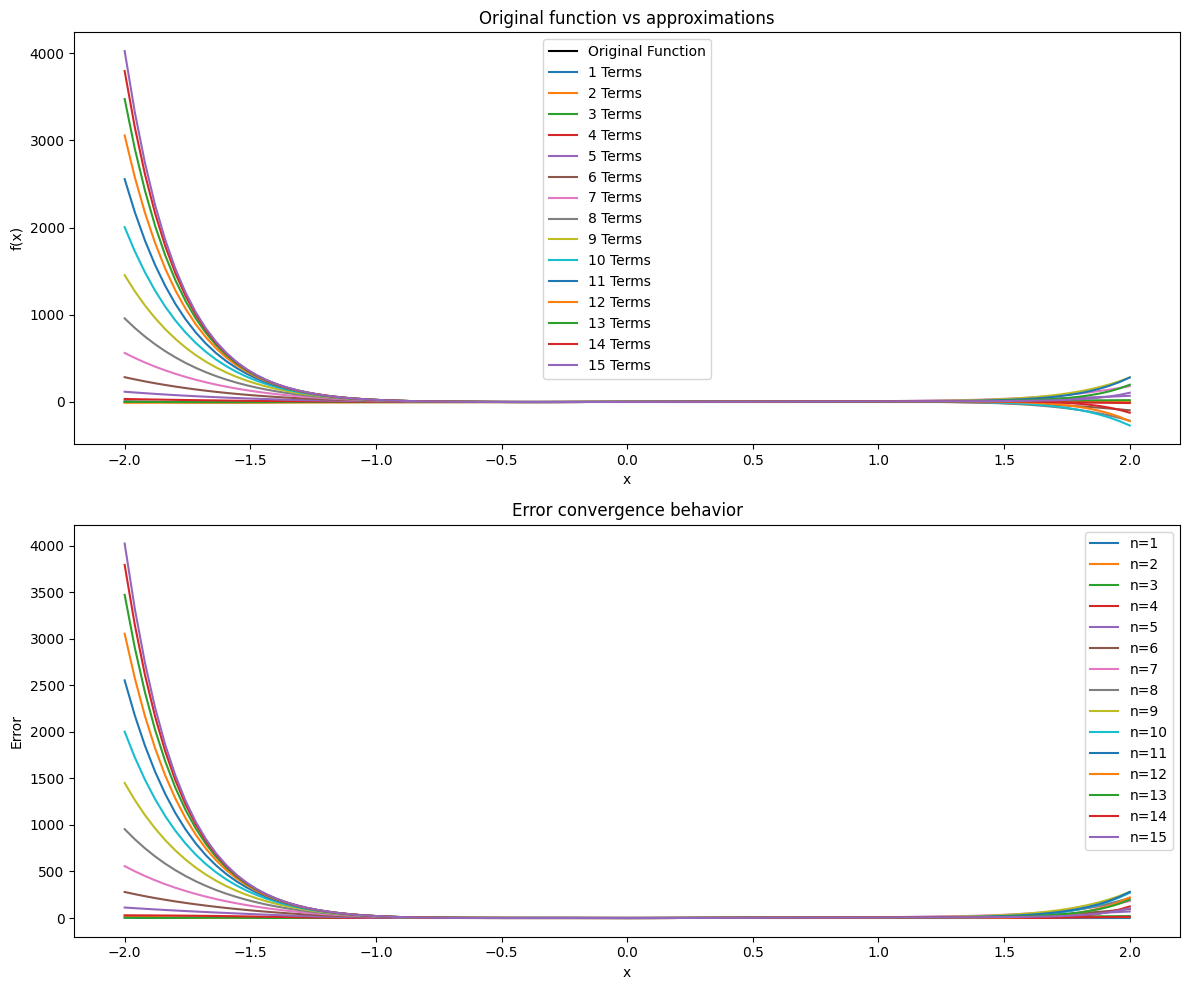

In [166]:
f, df = create_test_function()
taylor_expansion = TaylorExpansion(f, df)
x = np.linspace(-1, 1, 100)
x0 = 0
analyze_taylor_convergence(x, taylor_expansion, x0)


x = np.linspace(-2, 2, 100)
analyze_taylor_convergence(x, taylor_expansion, x0)

## Section 2: Optimized Newton's Polynomial Interpolation (40 Points)
### Background
Newton’s polynomial interpolation constructs a polynomial that passes through a given set of points. This method uses divided differences, which allows the interpolation polynomial to be calculated efficiently, especially when adding new points.

The divided differences formula is:
$f[x_0,x_1,\ldots,x_k] = \frac{f[x_1,\ldots,x_k] - f[x_0,\ldots,x_{k-1}]}{x_k-x_0}$

### Task 2.1: Vectorized Implementation (20 points)
**Step 1:** Begin by constructing the divided difference table, where each entry represents the divided difference for a subset of data points. Avoid using nested loops, which are inefficient, and instead leverage numpy for vectorized calculations.

**Step 2:** Write a recursive function (or use Horner’s method) to evaluate the Newton polynomial at any given point. Remember that each new term involves a product of previous terms multiplied by the current divided difference.

**Example:** If implementing Horner’s method, express the polynomial in a nested form:

$$
P(x) = a_0 + (x - x_0) \left( a_1 + (x - x_1) \left( a_2 + \dots \right) \right)
$$

This recursive evaluation minimizes computation by reducing operations.

In [122]:
class NewtonInterpolation:
    """
    Efficient implementation of Newton's polynomial interpolation.
    """
    def __init__(self, x: np.ndarray, y: np.ndarray):
        """
        Initialize with data points.

        Args:
            x: x coordinates
            y: y coordinates
        """
        self.x = x
        self.y = y
        self.coefficients = None

    def compute_divided_differences(self) -> np.ndarray:
        """
        Compute divided differences table using vectorized operations.

        Returns:
            Array of divided difference coefficients
        """
        n = len(self.x)
        diff_table = np.zeros((n, n))
        diff_table[:, 0] = self.y
        for j in range(1, n):
            diff_table[:n-j, j] = (diff_table[1:n-j+1, j-1] - diff_table[:n-j, j-1]) / (self.x[j:] - self.x[:-j])
        self.coefficients = diff_table[0, :]
        return self.coefficients

    def evaluate(self, x_eval: np.ndarray) -> np.ndarray:
        """
        Evaluate Newton polynomial using Horner's method.

        Args:
            x_eval: Points at which to evaluate polynomial

        Returns:
            Interpolated values
        """
        n = len(self.coefficients)
        result = np.zeros_like(x_eval, dtype=float)
        for i in range(n-1, -1, -1):
            result = result * (x_eval - self.x[i]) + self.coefficients[i]
        return result

### Task 2.2: Performance Analysis (20 points)
**Step 1:** Generate a dataset with points sampled from a complex function, such as $f(x) = \cos(x) + 0.5 \sin(3x)$ with 50–100 points.

**Step 2:** Measure runtime for your optimized, vectorized interpolation versus a standard loop-based approach using Python’s time module or %timeit in Jupyter.

**Step 3:** Plot runtime vs. number of points to observe performance differences.

In [156]:
import time
def compare_interpolation_performance(n_points: List[int]) -> None:
    """
    Compare performance of vectorized vs loop-based implementation.

    Args:
        n_points: List of different dataset sizes to test
    """
    vectorized_times = []
    loop_times = []
    vectorized_errors = []
    loop_errors = []

    for n in n_points:
        x = np.linspace(0, 10, n)
        y = np.cos(x) + 0.5 * np.sin(3 * x)
        x_eval = np.linspace(0, 10, 1000)
        y_true = np.cos(x_eval) + 0.5 * np.sin(3 * x_eval)
        start_time = time.time()
        vectorized_interp = NewtonInterpolation(x, y)
        vectorized_interp.compute_divided_differences()
        y_pred_vectorized = vectorized_interp.evaluate(x_eval)
        vectorized_times.append(time.time() - start_time)
        vectorized_errors.append(np.mean((y_pred_vectorized - y_true) ** 2))
        start_time = time.time()
        n = len(x)
        diff_table = np.zeros((n, n))
        diff_table[:, 0] = y
        for j in range(1, n):
            for i in range(n - j):
                diff_table[i, j] = (diff_table[i + 1, j - 1] - diff_table[i, j - 1]) / (x[i + j] - x[i])
        loop_coefficients = diff_table[0, :]
        n = len(loop_coefficients)
        y_pred_loop = np.zeros_like(x_eval, dtype=float)
        for i in range(n-1, -1, -1):
            y_pred_loop = y_pred_loop * (x_eval - x[i]) + loop_coefficients[i]
        loop_times.append(time.time() - start_time)
        loop_errors.append(np.mean((y_pred_loop - y_true) ** 2))
    plt.figure(figsize=(10, 6))
    plt.plot(n_points, vectorized_times, label="Vectorized", marker='o')
    plt.plot(n_points, loop_times, label="Loop-based", marker='o')
    plt.xlabel("Number of Points")
    plt.ylabel("Runtime (seconds)")
    plt.title("Performance Comparison of Interpolation Methods")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(n_points, vectorized_errors, label="Vectorized - Error", marker='o')
    plt.plot(n_points, loop_errors, label="Loop-based - Error", marker='o')
    plt.xlabel("Number of Points")
    plt.ylabel("Mean Squared Error")
    plt.title("Error Comparison of Interpolation Methods")
    plt.legend()
    plt.show()

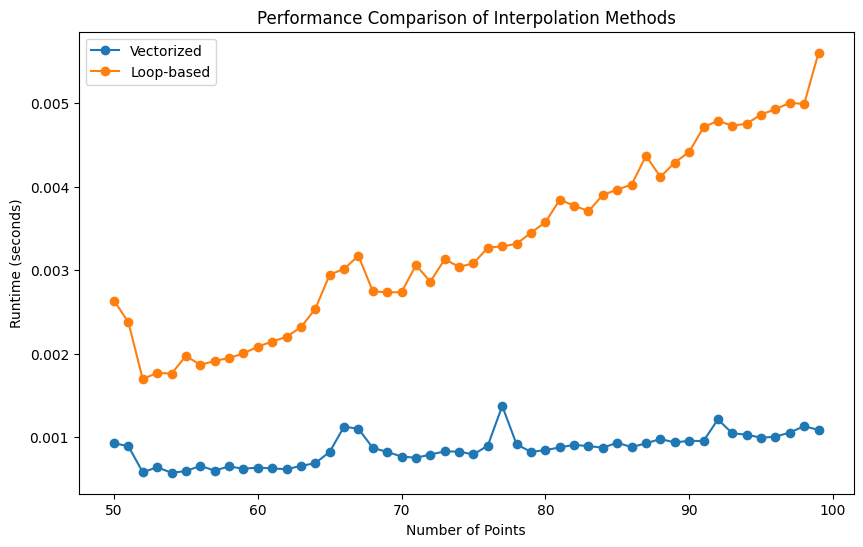

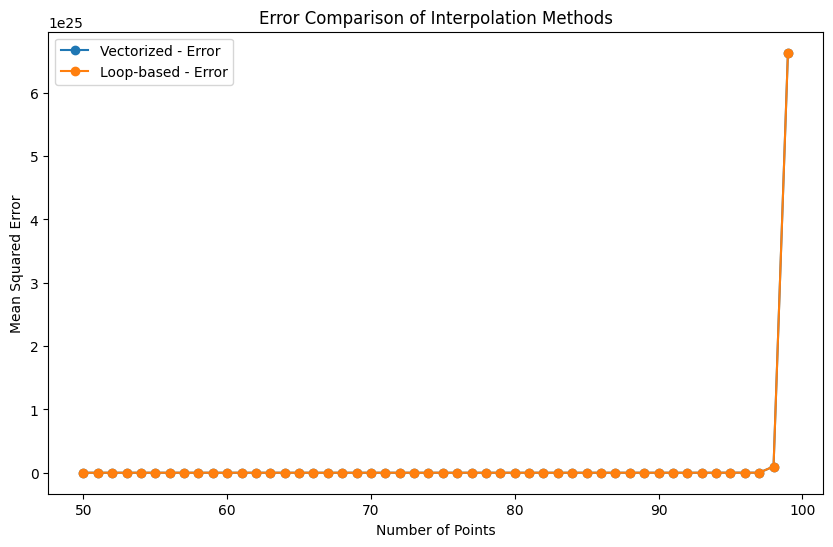

In [157]:
n_points = np.arange(50, 100)
compare_interpolation_performance(n_points)

## Section 3: Extended Cubic Spline Interpolation (30 Points)
### Background
Cubic splines are piecewise polynomials used for interpolation. Natural cubic splines have zero second derivatives at their endpoints, while clamped splines enforce specified first derivatives. These boundary conditions affect the smoothness and accuracy of the interpolated curve, particularly near endpoints.

### Task 3.1: Custom Boundary Conditions (20 points)
**Step 1:** For a natural spline, set up a tridiagonal system of equations where the second derivatives at the endpoints are zero. This will yield a smooth transition across segments.

**Step 2:** For a clamped spline, allow user-specified first derivatives at both ends. Modify the system of equations to incorporate these boundary constraints. For instance, the first and last rows of the system should reflect the first derivatives.

**Hint:** Review the mathematics of cubic splines if you are unfamiliar with constructing the tridiagonal system. Each segment should ensure continuity in the function, its first derivative, and second derivative.

In [159]:
class CubicSpline:
    """
    Cubic spline interpolation with flexible boundary conditions.
    """
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y
        self.coefficients = None

    def compute_coefficients(self,
                           boundary_type: str = 'natural',
                           derivatives: Tuple[float, float] = None) -> None:
        """
        Compute spline coefficients.

        Args:
            boundary_type: 'natural' or 'clamped'
            derivatives: (left_derivative, right_derivative) for clamped case
        """
        n = len(self.x) - 1
        h = np.diff(self.x)
        alpha = np.zeros(n+1)

        if boundary_type == 'natural':
            alpha[1:n] = 3 * (self.y[2:] - self.y[1:-1]) / h[1:] - 3 * (self.y[1:-1] - self.y[:-2]) / h[:-1]
        elif boundary_type == 'clamped':
            left_slope, right_slope = derivatives
            alpha[0] = 3 * (self.y[1] - self.y[0]) / h[0] - 3 * left_slope
            alpha[n] = 3 * right_slope - 3 * (self.y[n] - self.y[n-1]) / h[n-1]
            alpha[1:n] = 3 * (self.y[2:] - self.y[1:-1]) / h[1:] - 3 * (self.y[1:-1] - self.y[:-2]) / h[:-1]

        l = np.zeros(n+1)
        mu = np.zeros(n)
        z = np.zeros(n+1)
        l[0] = 1 if boundary_type == 'natural' else 2 * h[0]
        mu[0] = 0 if boundary_type == 'natural' else 0.5
        z[0] = 0 if boundary_type == 'natural' else alpha[0] / l[0]

        for i in range(1, n):
            l[i] = 2 * (self.x[i+1] - self.x[i-1]) - h[i-1] * mu[i-1]
            mu[i] = h[i] / l[i]
            z[i] = (alpha[i] - h[i-1] * z[i-1]) / l[i]

        l[n] = 1 if boundary_type == 'natural' else h[n-1] * (2 - mu[n-1])
        z[n] = 0 if boundary_type == 'natural' else (alpha[n] - h[n-1] * z[n-1]) / l[n]

        b = np.zeros(n)
        c = np.zeros(n+1)
        d = np.zeros(n)
        c[n] = z[n]

        for j in range(n-1, -1, -1):
            c[j] = z[j] - mu[j] * c[j+1]
            b[j] = (self.y[j+1] - self.y[j]) / h[j] - h[j] * (c[j+1] + 2 * c[j]) / 3
            d[j] = (c[j+1] - c[j]) / (3 * h[j])

        self.coefficients = [(self.y[i], b[i], c[i], d[i]) for i in range(n)]


    def evaluate(self, x_eval: np.ndarray) -> np.ndarray:
        """
        Evaluate spline at given points.

        Args:
            x_eval: Points at which to evaluate spline

        Returns:
            Interpolated values
        """
        results = np.zeros_like(x_eval)
        for i, xi in enumerate(x_eval):
            for j in range(len(self.x) - 1):
                if self.x[j] <= xi <= self.x[j+1]:
                    dx = xi - self.x[j]
                    a, b, c, d = self.coefficients[j]
                    results[i] = a + b * dx + c * dx**2 + d * dx**3
                    break
        return results

### Task 3.2: Boundary Condition Analysis (10 points)
**Step 1:** Generate sample data that captures variations in behavior at endpoints (e.g., rapidly increasing/decreasing values).

**Step 2:** Fit both natural and clamped splines, then plot the results on the same graph. Use markers at endpoints and a zoomed-in view to clearly observe boundary behavior.



In [163]:
def compare_boundary_conditions() -> None:
    """
    Compare natural and clamped cubic splines.
    """
    x = np.array([0, 1, 2, 3, 4, 5])
    y = np.array([0, 1, 0, 1, 0, 1])

    natural_spline = CubicSpline(x, y)
    natural_spline.compute_coefficients(boundary_type='natural')

    clamped_spline = CubicSpline(x, y)
    clamped_spline.compute_coefficients(boundary_type='clamped', derivatives=(1, -1))

    x_eval = np.linspace(0, 5, 500)
    y_natural = natural_spline.evaluate(x_eval)
    y_clamped = clamped_spline.evaluate(x_eval)

    plt.figure(figsize=(12, 6))
    plt.plot(x_eval, y_natural, label='Natural Spline', linestyle='--')
    plt.plot(x_eval, y_clamped, label='Clamped Spline')
    plt.scatter(x, y, color='red', label='Data Points')
    plt.scatter([x[0], x[-1]], [y[0], y[-1]], color='blue', label='Endpoints', zorder=10)
    plt.legend()
    plt.title('Natural vs Clamped Cubic Splines')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    plt.figure(figsize=(10, 6))
    dy_natural = np.gradient(y_natural, x_eval)
    dy_clamped = np.gradient(y_clamped, x_eval)

    plt.plot(x_eval, dy_natural, label='Natural Spline', linestyle='--')
    plt.plot(x_eval, dy_clamped, label='Clamped Spline')
    plt.legend()
    plt.title("First Derivative")
    plt.xlabel("x")
    plt.ylabel("dy/dx")
    plt.show()

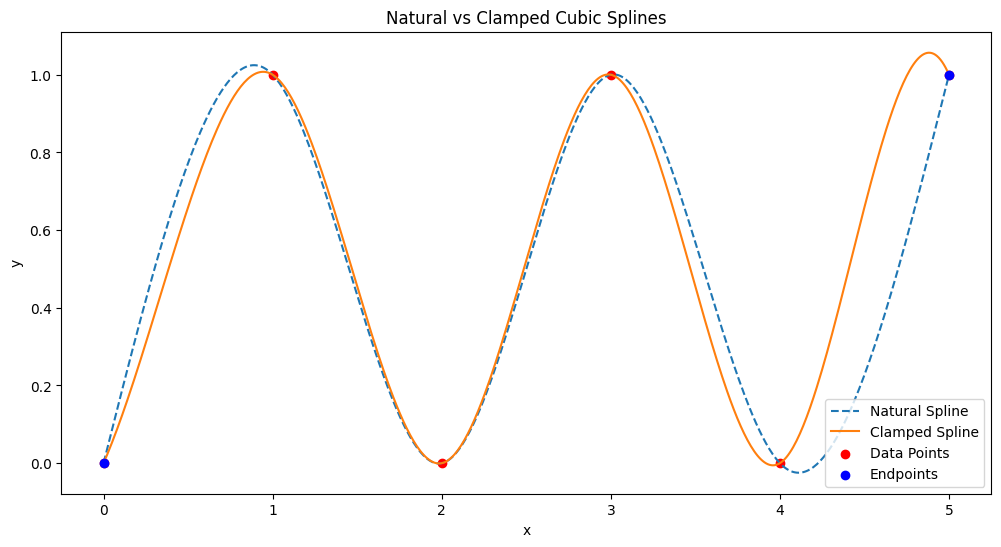

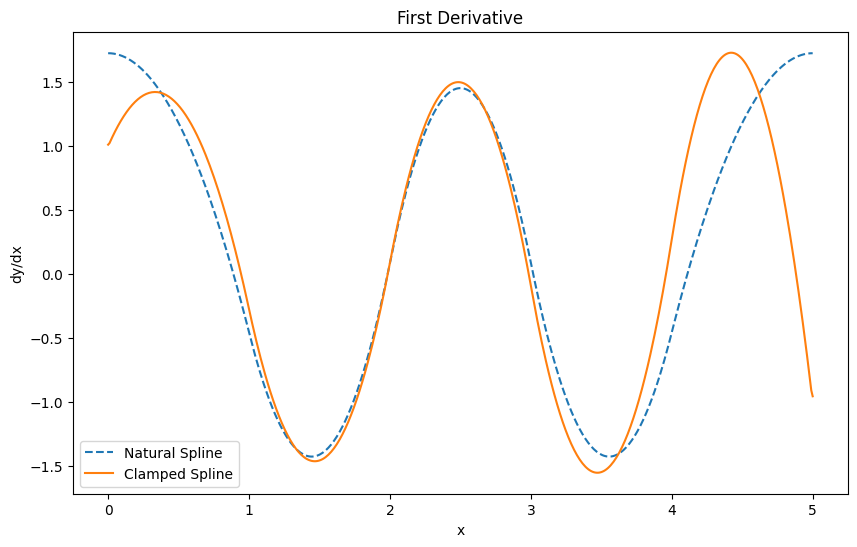

In [164]:
compare_boundary_conditions()

## Final Conceptual Questions (10 Points)
Briefly explain:
1. Based on your implementations and analysis:
   - Compare the computational efficiency of Taylor series vs interpolation methods

    Taylor Series:
Efficient when the function is analytic and derivatives are readily available.
Computational cost involves evaluating derivatives and powers of terms.
Convergence can be slow for functions with complex behavior, particularly far from the expansion point.
Limited by the radius of convergence.

    Interpolation Methods:
Typically require solving a system of equations to determine coefficients, which can be computationally intensive, especially for higher-degree polynomials.
Once coefficients are computed, evaluation at new points is efficient.
Cubic splines are computationally efficient due to their piecewise nature and the use of low-degree polynomials.

2. Consider practical applications:
   - When would you choose splines over polynomial interpolation?
    
    Avoiding Oscillations:
Splines: Ideal for large datasets. Avoids the Runge phenomenon (oscillations at the edges of the interval) by using piecewise cubic polynomials.
Polynomial Interpolation: May lead to instability and oscillations as the degree increases.

    Smoothness:
Splines guarantee smoothness (continuous first and second derivatives), making them suitable for applications requiring smooth transitions (e.g., computer graphics, robotics).

    Local Control:
Splines: Modifying one data point affects only the coefficients of nearby intervals, preserving the rest of the curve.
Polynomial Interpolation: Changing a single data point affects the entire polynomial, leading to a global recalculation.